# Quality Assessment
**Data Quality** refers to certain attributes that a dataset or group of datasets possess, such as completeness, consistency or reliability.

The DataFrames are connected relationally (each row in ``orders`` should correspond to one or more rows in ``orderlines``, and every product sold should be present in the ``products`` table…). This is something that SQL databases ensure by having database constraints (Primary and Foreign Keys). CSV files and Pandas DataFrames do not have to follow these rules: we have gained flexibility at the expense of consistency.

In this notebook, we go through some steps to ensure Data Quality.

We first need to import the Pandas module:

In [2]:
import pandas as pd

Load our cleaned DataFrames

In [4]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1fREDgOkyVShBiSKcE_ryWTRS7c-mom1W/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path, parse_dates=["created_date"])
# To have the `created_date` column as datetime64[ns] we can use parse command, since `created_date`appears an object everytime we import it.

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1QoyNpoY9tMdqKGcx-FnRl4C96OMKFvz4/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path, parse_dates=["date"])

# products_cl.csv
url = "https://drive.google.com/file/d/1b9MQQa_NRUiIiGgM7-BVznXgTYePkeZ6/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

In [8]:
orders_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226904 entries, 0 to 226903
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226904 non-null  int64         
 1   created_date  226904 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226904 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.9+ MB


In [9]:
orderlines_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216250 entries, 0 to 216249
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                216250 non-null  int64         
 1   id_order          216250 non-null  int64         
 2   product_id        216250 non-null  int64         
 3   product_quantity  216250 non-null  int64         
 4   sku               216250 non-null  object        
 5   unit_price        216250 non-null  float64       
 6   date              216250 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 11.5+ MB


## 1.&nbsp; Define Pandas display format

Checking for data quality often means scrutinising raw data, and using pandas in Jupyter notebooks often prevents you from having this completeness. You can change that by running the following lines at the top of your notebook:

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

## 2.&nbsp; Exclude unwanted orders

In [10]:
orders_cl.groupby('state')[['total_paid']].sum()

,total_paid
state,
Cancelled,5545816.86
Completed,15910079.24
Pending,4703300.72
Place Order,17087858.32
Shopping Basket,85912559.93


Some of the orders present in the dataset were left in the shopping cart or cancelled. As the first step of data cleaning, consider excluding them so that, when you analyse the dataset, you deal with actual purchases from which the company is making actual money. Analysing why some orders were cancelled could be very interesting, but it is out of the scope of this project.

In [7]:
# Filter to completed orders
state_mask = orders_cl['state'] == 'Completed'
# Apply filter
orders_completed = orders_cl.loc[state_mask].copy()

In [11]:
orders_completed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46605 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      46605 non-null  int64         
 1   created_date  46605 non-null  datetime64[ns]
 2   total_paid    46605 non-null  float64       
 3   state         46605 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


We should make sure that orders in the dataset are in both ``orders`` and ``orderlines``. Otherwise, we might consider orders that do not have products associated with them or products sold without an order that links them with the customers and sellers involved.

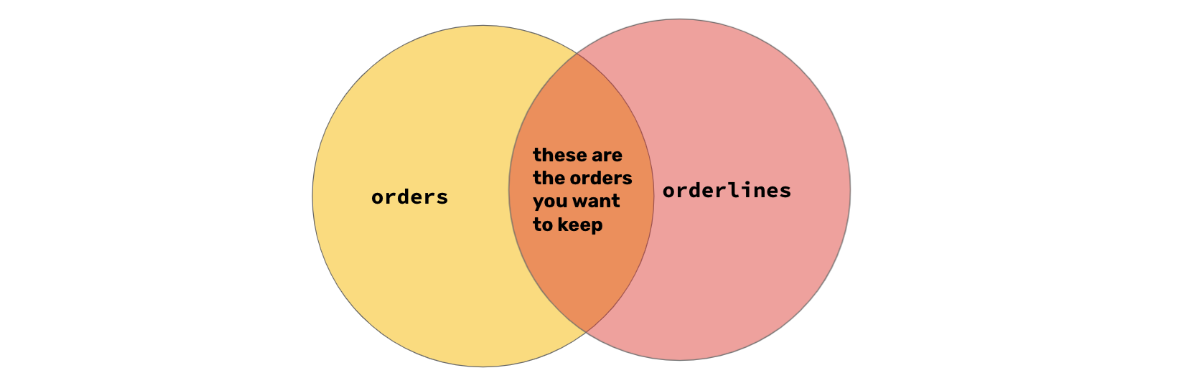

In summary, these three simple steps should do the trick:

* ``orders`` –> Keep only orders with the states that you want to work with (state == 'Completed').
* ``orderlines`` –> Keep only orders present in ``orders``.
* ``orders`` –> Keep only orders present in ``orderlines``.

In [13]:
# Filter orderlines to only those in completed orders

# Get order ids of completed orders
completed_order_ids = orders_completed['order_id']

# Filter orderlines to just those completed orders
orderlines_state_mask = orderlines_cl['id_order'].isin(completed_order_ids)

# Apply filter
orderlines_completed = orderlines_cl.loc[orderlines_state_mask].copy()

In [14]:
# Looking for orderlines with no orders
set(orderlines_completed['id_order']) - set(orders_completed['order_id'])

set()

In [15]:
# Looking for orders with no orderlines
set(orders_completed['order_id'])  - set(orderlines_completed['id_order'])

{393219,
 521032,
 516103,
 319497,
 352267,
 475148,
 499725,
 434192,
 466962,
 401427,
 352276,
 368661,
 426006,
 434199,
 507922,
 344089,
 417821,
 376861,
 516129,
 426018,
 442402,
 475171,
 466992,
 475184,
 466998,
 467000,
 360505,
 385080,
 499774,
 516160,
 434242,
 426051,
 475202,
 376901,
 319558,
 360519,
 475208,
 303185,
 467026,
 442451,
 360532,
 499794,
 393309,
 360544,
 409699,
 360551,
 434281,
 303210,
 360553,
 499818,
 434287,
 499827,
 499828,
 319606,
 401528,
 360569,
 483458,
 401545,
 409737,
 467085,
 409742,
 475278,
 426128,
 475279,
 393362,
 360594,
 508052,
 393365,
 311445,
 352408,
 467099,
 516252,
 401565,
 393374,
 368799,
 467114,
 344234,
 467116,
 344242,
 360627,
 245941,
 426167,
 311482,
 311492,
 483526,
 377035,
 360661,
 303319,
 344285,
 483549,
 311522,
 483557,
 467174,
 458986,
 418033,
 483570,
 483574,
 467194,
 516348,
 467198,
 311553,
 401668,
 426249,
 467211,
 483595,
 344333,
 352529,
 491794,
 434451,
 483607,
 393496,
 

In [16]:
# Removing orders that have no orderlines

# Get collection of orders that are in the orderlines table
existing_orderlines = orderlines_completed['id_order'].copy()

# Filter to just orders in orderlines table
overlap_mask = orders_completed['order_id'].isin(existing_orderlines)

# Apply filter
orders_coherent = orders_completed.loc[overlap_mask].copy()

## 3.&nbsp; Exclude orders with unknown products


The products table should be the primary reference for all the products being sold. During the Data Cleaning phase, we deleted many rows from products. Any order involving products not present there is susceptible to containing corrupted information.

A conservative way to deal with this would be to delete all of the potentially corrupted rows. In the example below, you would delete all of the rows shadowed in red:

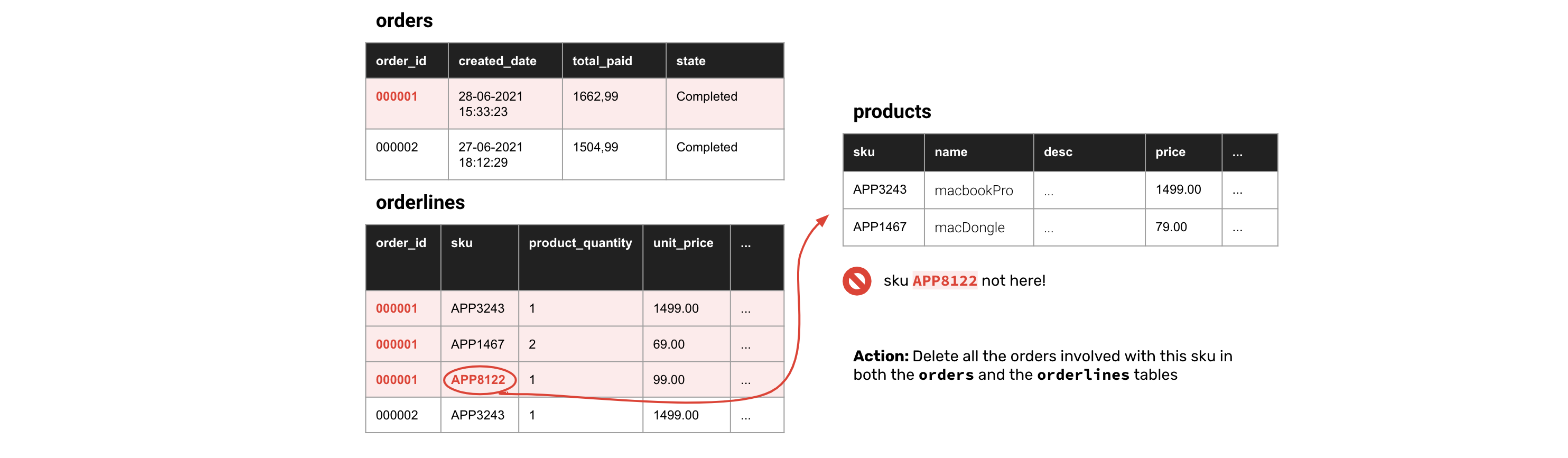

In [17]:
# Remove all orders and orderlines if any orderline's product is missing

# 1. Identify corrupted orderlines (missing their products)
# (Note: This could be done more concisely)

# Identify products we actually have information about
existing_products = products_cl['sku']
# Create new column to track the status of the orderline
orderlines_completed.loc[:, 'Corrupted'] = False
# Identify orderlines with existing products
products_there_mask = orderlines_completed['sku'].isin(existing_products)
# Label all orderlines with *missing* products corrupted
orderlines_completed.loc[~products_there_mask, 'Corrupted'] = True


# 2. Identify corrupted orders (with corrupted orderlines)

# Filter to corrupted orderlines
corrupted_mask = orderlines_completed['Corrupted']==True
# Identify which orders they are in
corrupted_orders = orderlines_completed.loc[corrupted_mask, 'id_order']


# 3. Filter our dataframe by corrupted orders

# Creating filters to remove corrupted orders from both data frame
corrupted_orders_mask = orders_coherent['order_id'].isin(corrupted_orders)
corrupted_orderlines_mask = orderlines_completed['id_order'].isin(corrupted_orders)
# Applying filters
orders_qu = orders_coherent.loc[~corrupted_orders_mask]
orderlines_qu = orderlines_completed.loc[~corrupted_orderlines_mask]

In [18]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41701 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      41701 non-null  int64         
 1   created_date  41701 non-null  datetime64[ns]
 2   total_paid    41701 non-null  float64       
 3   state         41701 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [19]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54324 entries, 6 to 215949
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                54324 non-null  int64         
 1   id_order          54324 non-null  int64         
 2   product_id        54324 non-null  int64         
 3   product_quantity  54324 non-null  int64         
 4   sku               54324 non-null  object        
 5   unit_price        54324 non-null  float64       
 6   date              54324 non-null  datetime64[ns]
 7   Corrupted         54324 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.4+ MB


## 4.&nbsp; Explore the revenue from different tables

All three tables we have seen (products, orderlines and orders) contain information about prices. Shouldn’t this information match? Well… yes and no. There are subtle differences:

  *  ``products.price`` –> this is the original price of a product, without any discount or promotion.
  *  ``orderlines.unit_price`` –> this is the actual price at which a product has been sold. It should *roughly* match the price in the products table, but there might be deviations, as discounts get applied here.
  *  ``orders.total_paid`` –> this is the total amount of the full order. It should *roughly* translate to the sum of all unitary prices, multiplied by the amount of each product purchased (``orderlines.product_quantity``). The key word here is, again, *roughly*: the total amount of the order might include shipping costs or vouchers.

A good place to start is to compare ``orders.total_paid`` with ``orderlines.unit_price`` * ``orderlines.product_quantity``. This comparison will require you to start by reshaping the orderlines table:

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu.loc[:, 'unit_price_total'] = orderlines_qu['unit_price'] * orderlines_qu['product_quantity'].copy()

In [23]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54324 entries, 6 to 215949
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                54324 non-null  int64         
 1   id_order          54324 non-null  int64         
 2   product_id        54324 non-null  int64         
 3   product_quantity  54324 non-null  int64         
 4   sku               54324 non-null  object        
 5   unit_price        54324 non-null  float64       
 6   date              54324 non-null  datetime64[ns]
 7   Corrupted         54324 non-null  bool          
 8   unit_price_total  54324 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 3.8+ MB


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [24]:
total_item_prices = (
    orderlines_qu
    .groupby('id_order')
    .agg({'unit_price_total': 'sum'})
)
total_item_prices

,unit_price_total
id_order,
241423,129.16
242832,10.77
243330,77.99
245275,149.00
245595,105.98
...,...
527042,13.99
527070,19.98
527074,19.98


The grouped orderlines table can be merged with the orders table to easily compare the numbers:

In [25]:
orders_combined = orders_qu.merge(total_item_prices,
                left_on = 'order_id',
                right_on = 'id_order',
                how = 'left'
                )
orders_combined

,order_id,created_date,total_paid,state,unit_price_total
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98
...,...,...,...,...,...
41696,527042,2018-03-14 11:47:50,18.98,Completed,13.99
41697,527070,2018-03-14 11:50:48,24.97,Completed,19.98
41698,527074,2018-03-14 11:51:42,24.97,Completed,19.98
41699,527096,2018-03-14 11:58:40,34.96,Completed,29.97


* Let's explore the revenue by answering some questions:

### 4.1.&nbsp; What is the average difference between `total_paid` and `unit_price_total`?

In [26]:
orders_combined.loc[:, 'difference'] = orders_combined['total_paid'] - orders_combined['unit_price_total']

In [27]:
orders_combined

,order_id,created_date,total_paid,state,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
...,...,...,...,...,...,...
41696,527042,2018-03-14 11:47:50,18.98,Completed,13.99,4.99
41697,527070,2018-03-14 11:50:48,24.97,Completed,19.98,4.99
41698,527074,2018-03-14 11:51:42,24.97,Completed,19.98,4.99
41699,527096,2018-03-14 11:58:40,34.96,Completed,29.97,4.99


In [28]:
orders_combined['difference'].describe()

count   41701.00
mean        4.47
std        26.05
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

### 4.2.&nbsp;  What is the distribution of these differences?

<Axes: >

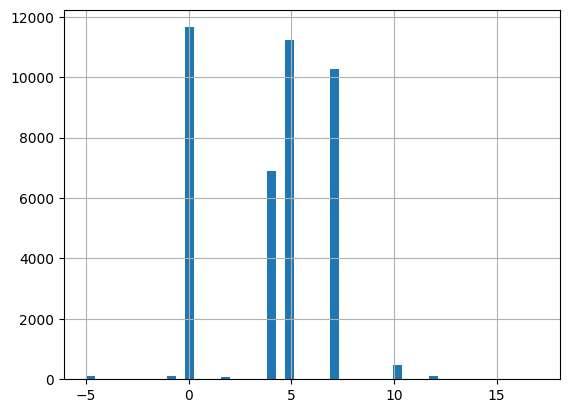

In [29]:
# Filtering out orderlines according to the statistical principle
q1 = orders_combined['difference'].quantile(0.25)
q2 = orders_combined['difference'].quantile(0.50)
q3 = orders_combined['difference'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)

above_lower_bound = orders_combined['difference'] > lower_bound
below_upper_bound = orders_combined['difference'] < upper_bound

orders_combined.loc[above_lower_bound & below_upper_bound, 'difference'].hist(bins=50)

Could there be reasonable deviations that are outside of this range?

Statistics gives us a rule, but in terms of cleaning this is more of a guideline. We just want to remove values that are unreasonable, but this is a somewhat subjective assessment.

In [30]:
print(lower_bound, upper_bound)

-10.484999999999971 17.47499999999995


### 4.3.&nbsp; Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

* diff_paid_selling = total_paid - unit_price_tot_order
* diff_paid_selling > 0 : shipping (It can be for expenses like insurance if the diff is a very large amount)
* diff_paid_selling < 0 : Due to using a discount voucher or some money left in the account from previous cancellation or changing orders
* Larger positive ones could be due to missing orderlines

### 4.4.&nbsp; If there are differences that you can’t explain: what should you do with these orders?

* We may consider dropping them, but if we do, we should make sure to drop the corresponding orderlines as well.

## 5.&nbsp; Save the quality controlled DataFrames
Do not forget to download your quality controlled DataFrames

In [ ]:
#files.download("orders_qu.csv")
orders_qu.to_csv("orders_qu.csv", index=False)

In [ ]:
#files.download("orderlines_qu.csv")
orderlines_qu.to_csv("orderlines_qu.csv", index=False)